Neste Jupyter vamos baixar um dataset e criar a segmentação das imagens para utilizar no treinamento de nossa CNN

In [ ]:
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ug5w68zp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ug5w68zp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx pillow matplotlib kagglehub "transformers[torch]"==4.49.0 einops timm

  Using cached onnxruntime-1.23.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.0 kB)
  Using cached onnx-1.19.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (7.0 kB)
  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached timm-1.0.20-py3-none-any.whl.metadata (61 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.35.3-py3-none-any.whl.metadata (14 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached torch-2.8.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached accelerate-1.10.1-py3-none-any.whl.metadata (19 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (

In [3]:
import kagglehub

# dataset_path = "splcher/animefacedataset"
dataset_path = "diraizel/anime-images-dataset"

path = kagglehub.dataset_download(dataset_path)
print("Caminho para o dataset:" + path)


/mnt/c/Users/Lucas/Documents/projetos/fiap_fase6_cap1/.venv_segmentacao/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Caminho para o dataset:/home/lucas/.cache/kagglehub/datasets/diraizel/anime-images-dataset/versions/1


A segir, vamos mostrar algumas imagens apenas para ilustração

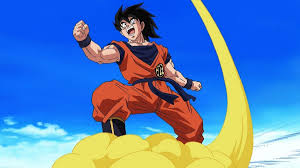

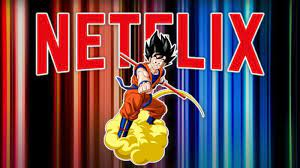

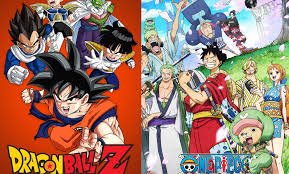

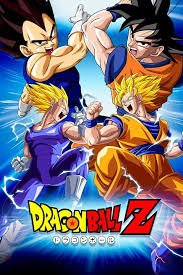

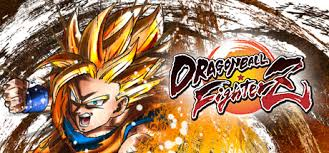

In [4]:
from PIL import Image
from IPython.display import display
import os

image_folder = os.path.join(path, "data", "anime_images")

# Listar algumas imagens no diretório
for img_name in os.listdir(os.path.join(image_folder, 'Dragon Ball Z'))[:5]:
    img_path = os.path.join(image_folder, 'Dragon Ball Z', img_name)
    img = Image.open(img_path)
    display(img)

Agora vamos tentar segmentar apenas os personagens nas imagens, abaixo vamos baixar e instalar o Microsoft Florence-2-base

In [5]:
import torch
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print("Using torch dtype:", torch_dtype)

model_id = 'microsoft/Florence-2-base'
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

Using device: cuda:0
Using torch dtype: torch.float16


In [6]:
def run_florence2(image, task_prompt = '<OD>', text_input=None):
    
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input


    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

    generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=4096,
    num_beams=3,
    do_sample=False
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

    return parsed_answer




def plot_bbox(image, data):
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()




{'<OD>': {'bboxes': [[72.1500015258789, 1.7639999389648438, 205.35000610351562, 144.39599609375]], 'labels': ['character']}}


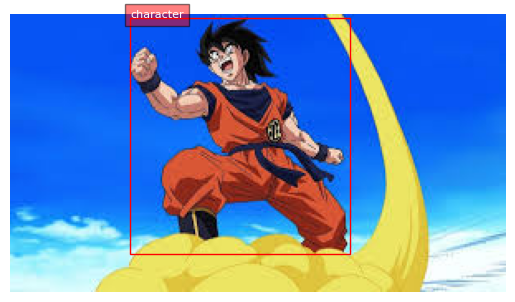

{'<OD>': {'bboxes': [[103.05000305175781, 28.47599983215332, 205.95001220703125, 165.39599609375]], 'labels': ['character']}}


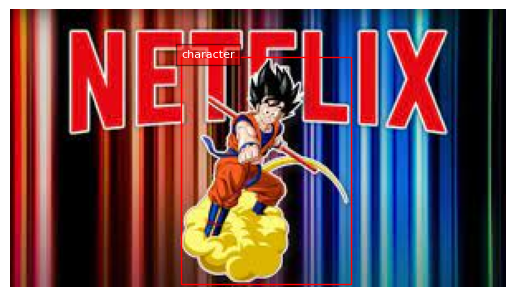

{'<OD>': {'bboxes': [[21.241500854492188, 38.01899719238281, 125.57050323486328, 162.60299682617188]], 'labels': ['character']}}


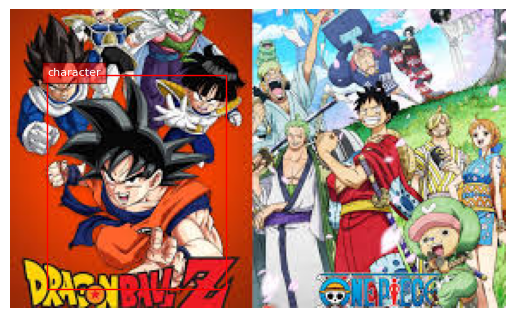

{'<OD>': {'bboxes': [[0.09149999916553497, 0.13750000298023224, 182.72549438476562, 274.5874938964844]], 'labels': ['character']}}


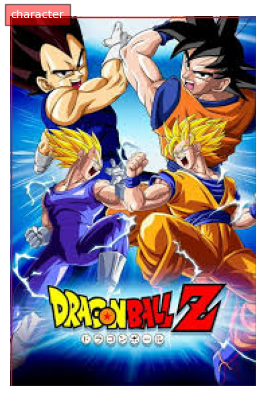

{'<OD>': {'bboxes': [[0.16449999809265137, 0.07649999856948853, 328.5065002441406, 152.31149291992188]], 'labels': ['character']}}


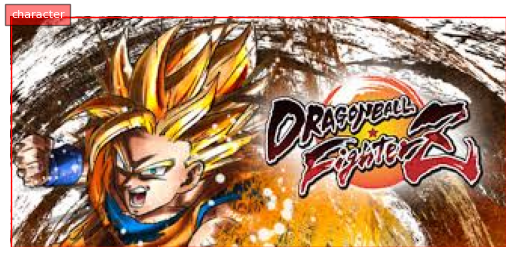

In [7]:
#prompt = "<OD>" # Abreviação de Object Detection - Simples sem prompt

prompt = "<CAPTION_TO_PHRASE_GROUNDING>" # Prompt para detecção de objetos com base em prompt textual

for img_name in os.listdir(os.path.join(image_folder, 'Dragon Ball Z'))[:5]:
    
    img_path = os.path.join(image_folder, 'Dragon Ball Z', img_name)
    img = Image.open(img_path)

    parsed_answer = run_florence2(img, task_prompt=prompt, text_input="character")
    print(parsed_answer)

    plot_bbox(img, parsed_answer['<OD>'])


Agora utilizaremos a bounding box do Florence para cortar as imagens e segmentálas com o SAM

In [8]:

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

#Agora utilizaremos a bounding box do Florence para cortar as imagens e segmentálas com o SAM

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [9]:
from segment_anything import SamPredictor
import numpy as np

predictor:SamPredictor = SamPredictor(sam)

def sam_segment_from_bboxes(pil_image, bboxes, predictor, multimask_output=True):
    """
    bboxes: list/array de [x1, y1, x2, y2] em pixels (se forem normalizadas 0..1 serão escaladas)
    Retorna lista de dicts: {'box': box, 'masks': [mask_arrays], 'scores': scores_array}
    """
    img_np = np.array(pil_image)
    h, w = pil_image.height, pil_image.width

    predictor.set_image(img_np)

    results = []
    for box in bboxes:
        box = np.array(box, dtype=float)
        # se bbox estiver normalizada (valores <= 1) escala para pixels
        if box.max() <= 1.0:
            box = box * np.array([w, h, w, h])
        box = box.astype(int)

        # predictor.predict aceita shape (N,4)
        masks, scores, logits = predictor.predict(box=box.reshape(1, 4), multimask_output=multimask_output)

        # masks: (n_masks, H, W) já no tamanho da imagem completa
        masks_list = [m.astype(np.uint8) for m in masks]  # 0/1 masks
        results.append({'box': box.tolist(), 'masks': masks_list, 'scores': scores})

    return results

def merge_masks_for_result(result, method='or', threshold=0.5):
    """
    result: dict {'box':..., 'masks': [H,W arrays 0/1], 'scores': np.array}
    method: 'or' | 'best' | 'weighted'
    returns: merged_mask (uint8 0/1)
    """
    masks = result.get('masks', [])
    scores = np.asarray(result.get('scores', []))
    if len(masks) == 0:
        return None
    stacked = np.stack(masks, axis=0).astype(float)  # (N,H,W)

    if method == 'or':
        merged = (stacked.max(axis=0) > 0).astype(np.uint8)
    elif method == 'best':
        if scores.size == 0:
            # fallback to first
            merged = (stacked[0] > 0).astype(np.uint8)
        else:
            best_idx = int(scores.argmax())
            merged = (stacked[best_idx] > 0).astype(np.uint8)
    elif method == 'weighted':
        if scores.size == 0:
            weights = np.ones((stacked.shape[0],), dtype=float)
        else:
            weights = scores.astype(float)
            weights = weights / (weights.sum() + 1e-8)
        weighted = (stacked * weights[:, None, None]).sum(axis=0)
        merged = (weighted >= threshold).astype(np.uint8)
    else:
        raise ValueError("method must be 'or', 'best' or 'weighted'")

    return merged

def show_mask_overlay(pil_image, mask, alpha=0.5, color=(1.0, 0, 0)):
    plt.figure(figsize=(6,6))
    plt.imshow(pil_image)
    plt.imshow(mask, cmap='Reds', alpha=alpha)
    plt.axis('off')
    plt.show()


A seguir um exemplo das máscaras seguimentadas

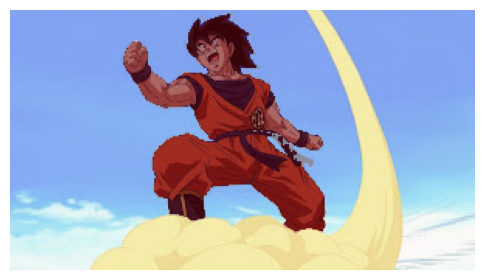

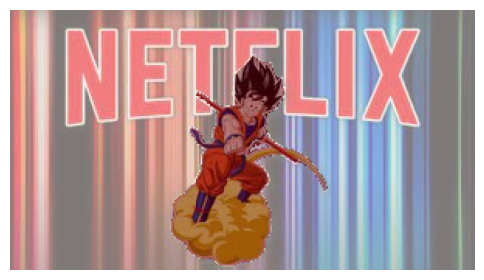

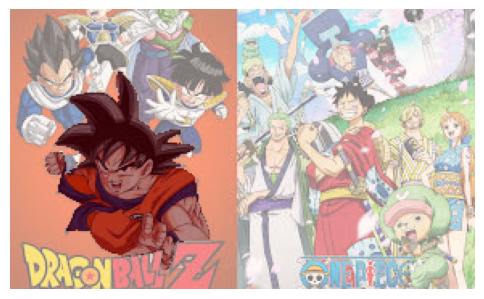

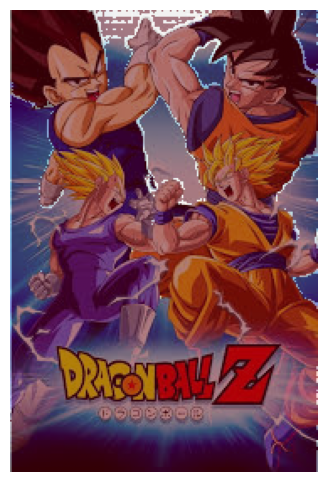

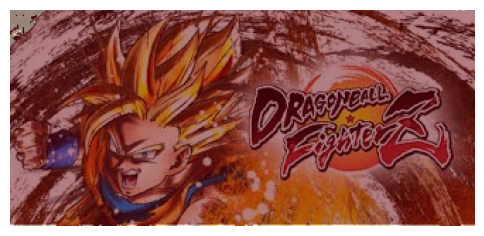

In [10]:

# Exemplo de uso com o parsed_answer do Florence
# parsed_answer['<OD>']['bboxes'] deve ser uma lista de bboxes compatíveis
for img_name in os.listdir(os.path.join(image_folder, 'Dragon Ball Z'))[:5]:
    img_path = os.path.join(image_folder, 'Dragon Ball Z', img_name)
    img = Image.open(img_path).convert("RGB")

    parsed_answer = run_florence2(img, task_prompt=prompt, text_input="character")
    bboxes = parsed_answer['<OD>']['bboxes']  # ajustar conforme formato real

    sam_results = sam_segment_from_bboxes(img, bboxes, predictor)

    # Mostrar primeira máscara de cada bbox
    for r in sam_results:
        if len(r['masks']) > 0:
            
            mask_merged = merge_masks_for_result(r, method='or')

            show_mask_overlay(img, mask_merged)  # mostra a máscara mesclada

Abaixo um exemplo das imagens cortadas a partir da seguimentação do SAM

In [11]:

def crop_from_mask(pil_image, mask, pad=5, transparent_bg=True):
    """
    mask: numpy array (H,W) com 0/1
    Retorna PIL Image recortada (RGBA se transparent_bg=True) ou None se máscara vazia.
    """
    mask_bool = (mask.astype(bool))
    if not mask_bool.any():
        return None

    ys, xs = np.where(mask_bool)
    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    # aplicar padding e limites
    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(pil_image.width - 1, x2 + pad)
    y2 = min(pil_image.height - 1, y2 + pad)

    # crop na imagem original
    cropped = pil_image.crop((x1, y1, x2 + 1, y2 + 1))

    if transparent_bg:
        # crop na máscara e converter para canal alfa
        mask_cropped = (mask_bool[y1:y2 + 1, x1:x2 + 1] * 255).astype('uint8')
        mask_img = Image.fromarray(mask_cropped, mode='L')
        # garantir que a imagem tem canal alfa
        if cropped.mode != 'RGBA':
            cropped = cropped.convert('RGBA')
        cropped.putalpha(mask_img)

    return cropped

/tmp/ipykernel_54789/2065719701.py:26: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_img = Image.fromarray(mask_cropped, mode='L')


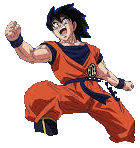

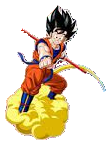

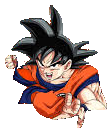

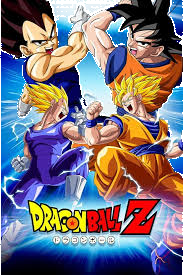

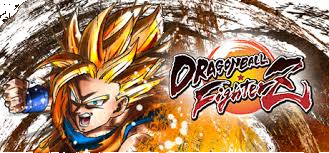

In [12]:
for img_name in os.listdir(os.path.join(image_folder, 'Dragon Ball Z'))[:5]:
    img_path = os.path.join(image_folder, 'Dragon Ball Z', img_name)
    img = Image.open(img_path).convert("RGB")

    parsed_answer = run_florence2(img, task_prompt=prompt, text_input="character")
    bboxes = parsed_answer['<OD>']['bboxes']  # ajustar conforme formato real

    sam_results = sam_segment_from_bboxes(img, bboxes, predictor)

    # Mostrar primeira máscara de cada bbox
    for r in sam_results:
        if len(r['masks']) > 0:
            
            mask_merged = merge_masks_for_result(r, method='or')

            image_cropped = crop_from_mask(img, mask_merged, pad=5, transparent_bg=True)
            if image_cropped is not None:
                display(image_cropped)

Por fim, vamos executar tudo no dataset e salvar as imagens cortadas em outra pasta. Pegaremos 30 imagens de cada Anime e salvaremos na estrura dataset/NomeAnime/NomeImagem

In [13]:
import os

if not os.path.exists('dataset_segmentado'):
    os.makedirs('dataset_segmentado')

anime_dirs = [
    "Dragon Ball Z",
    "Samurai X"
]

image_count_max = 30

for anime_name in anime_dirs:
    anime_folder = os.path.join(image_folder, anime_name)
    if not os.path.isdir(anime_folder):
        continue

    output_anime_folder = os.path.join('dataset_segmentado', anime_name)
    if not os.path.exists(output_anime_folder):
        os.makedirs(output_anime_folder)

    count = 0
    for img_name in os.listdir(anime_folder):
        if count >= image_count_max:
            break

        img_path = os.path.join(anime_folder, img_name)
        img = Image.open(img_path).convert("RGB")

        parsed_answer = run_florence2(img, task_prompt=prompt, text_input="character")
        bboxes = parsed_answer['<OD>']['bboxes']  # ajustar conforme formato real

        sam_results = sam_segment_from_bboxes(img, bboxes, predictor)

        for r in sam_results:
            if len(r['masks']) > 0:
                mask_merged = merge_masks_for_result(r, method='or')
                image_cropped = crop_from_mask(img, mask_merged, pad=5, transparent_bg=True)
                if image_cropped is not None:
                    output_path = os.path.join(output_anime_folder, f"{os.path.splitext(img_name)[0]}_segmented_{count}.png")
                    image_cropped.save(output_path)
                    count += 1
                    if count >= 10:
                        break

/tmp/ipykernel_54789/2065719701.py:26: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_img = Image.fromarray(mask_cropped, mode='L')
